plot chromHMM

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats


In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis


In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'E14':'mouse',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'E14':['chr%s' % (i) for i in range(1, 20)] + ['chrX', 'chrY'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}


In [5]:
agent_fullname = {'sp':'Spermine(4+)',
                  'spd':'Spermidine(3+)',
                  'CoH':'Cobalt Hexammine(3+)',
                  'PEG':'PEG 8000',
                  'HP1a':'HP1$\\alpha$',
                  'HP1bSUV':'HP1$\\beta$+tSUV',
                  'LKH':'Linker histone1',
                  'Ki67':'Ki67',
                  'FUS':'FUS',
                  'Mg':'Magnesium',
                  'Ca':'Calcium'}


In [6]:
## for H1
H1_name_dict = {"E1":"Polycomb repressed",
                "E2":"Poised promoter",
                "E3":"Weak promoter",
                "E4":"Strong enhancer",
                "E5":"Active promoter",
                "E6":"Weak enhancer",
                "E7":"Quiescence1",
                "E8":"Quiescence2",
                "E9":"Heterochromatin",
                "E10":"Tx elongation",
                "E11":"Weak Tx",
                "E12":"Insulator"}

# state for H1
H1_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence1", "Quiescence2"]

H1_HMM_fname = "H1_12_segments.bed"


In [7]:
# for GM12878
GM_name_dict = {"E1":"Polycomb repressed",
                "E2":"Quiescence",
                "E3":"Heterochromatin",
                "E4":"Weak Tx",
                "E5":"Tx elongation",
                "E6":"Weak enhancer",
                "E7":"Active enhancer",
                "E8":"Strong enhancer",
                "E9":"Active promoter",
                "E10":"Weak promoter",
                "E11":"Poised promoter",
                "E12":"Insulator"}

# state for GM
GM_states = ["Active promoter", "Weak promoter", "Poised promoter", "Strong enhancer", "Active enhancer", "Weak enhancer", "Tx elongation", "Weak Tx", "Insulator", "Polycomb repressed", "Heterochromatin", "Quiescence"]

GM_HMM_fname = "GM12878_12_segments.bed"


In [8]:
# for mouse CD8 T cell
mCD8T_name_dict = {"E1":"Weak Tx",
                   "E2":"Tx elongation",
                   "E3":"Weak enhancer2",
                   "E4":"Strong enhancer2",
                   "E5":"Strong enhancer1",
                   "E6":"Weak enhancer1",
                   "E7":"Active promoter",
                   "E8":"Poised promoter",
                   "E9":"Polycomb repressed1",
                   "E10":"Polycomb repressed2",
                   "E11":"Quiescence",
                   "E12":"Heterochromatin"}

# state for mouse CD8 T cell
mCD8T_states = ["Active promoter", "Poised promoter", "Strong enhancer1", "Strong enhancer2", "Weak enhancer1", "Weak enhancer2", "Tx elongation", "Weak Tx", "Polycomb repressed1", "Polycomb repressed2", "Heterochromatin", "Quiescence"]

mCD8T_HMM_fname = "Mouse CD8 T cell (invitro activated)_12_segments.bed"


In [9]:
# for mouse E14 cell
E14_name_dict = {"E1":"Polycomb repressed",
                 "E2":"Quiescence",
                 "E3":"Heterochromatin",
                 "E4":"Weak Tx2",
                 "E5":"Tx elongation",
                 "E6":"Weak Tx1",
                 "E7":"Strong Tx",
                 "E8":"Weak promoter",
                 "E9":"Weak enhancer",
                 "E10":"Poised promoter2",
                 "E11":"Poised promoter1",
                 "E12":"Active promoter"}

# state for mouse E14 cell
E14_states = ["Active promoter",
              "Weak promoter",
              "Strong Tx",
              "Weak Tx1",
              "Weak Tx2",
              "Weak enhancer",
              "Poised promoter1",
              "Poised promoter2",
              "Tx elongation",
              "Polycomb repressed",
              "Heterochromatin",
              "Quiescence"]

E14_HMM_fname = "E14_12_segments.bed"

In [10]:
# data path
#path = './data/'
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

In [11]:
# chromHMM data set
cell_chromHMM = {'H1':[H1_HMM_fname, H1_name_dict, H1_states],
                 'GM':[GM_HMM_fname, GM_name_dict, GM_states],
                 'E14':[E14_HMM_fname, E14_name_dict, E14_states],
                 'mCD8T:WT':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states],
                 'mCD8T:DFMO':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states],
                 'mCD8T:ODCKO':[mCD8T_HMM_fname, mCD8T_name_dict, mCD8T_states]}


In [12]:
### set target cell
cell = 'GM'

In [13]:
### set target chromosomes
chr_choices = cell_chrnames[cell]
#chr_choices = ['chr1']

In [14]:
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'GM_NCP_sp_1rep_1kb_score_table.gtab.gz':
              {'GM_NCP_sp_%d_1rep' % (i) :(1, 'NCP', 'score', i) for i in range(1, 10)},
              'GM_synNCP_sp_1rep_1kb_score_table.gtab.gz':
              {'GM_synNCP_sp_%d_1rep' % (i) :(1, 'synNCP', 'score', i) for i in range(1, 10)}
              }

dinfo_dkey['GM_NCP_sp_1rep_1kb_score_table.gtab.gz']['ATcontent'] \
    = (1, 'NCP', 'ATcontent', 0)
dinfo_dkey['GM_synNCP_sp_1rep_1kb_score_table.gtab.gz']['ATcontent'] \
    = (1, 'synNCP', 'ATcontent', 0)

In [15]:
### load gtab file
dkey_chr_ID_value = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])
        field_chr_ID_value = load_file.read_gtab(fname,
                                                 mode='col',
                                                 field_choices=field_dkey.keys(),
                                                 by_chr=True)

        for field, dkey in field_dkey.items():
            chr_ID_value = field_chr_ID_value[field]

            if dkey not in dkey_chr_ID_value:
                dkey_chr_ID_value[dkey] = {}
            dkey_chr_ID_value[dkey].update(chr_ID_value)
        

loading GM_NCP_sp_1rep_1kb_score_table.gtab.gz


loading GM_synNCP_sp_1rep_1kb_score_table.gtab.gz


In [16]:
### loading the chromHMM data
chromHMM_path = '/Users/sangwoopark/jhu_rockfish/chromHMM_data/'

HMM_fname, name_dict, states = cell_chromHMM[cell]
chr_state_intervals = load_file.read_chromHMM(chromHMM_path + HMM_fname,
                                              state_name=name_dict,
                                              chr_choices=chr_choices)

In [17]:
### categorize by chromHMM
dkey_state_IDs = {}
for dkey in dkey_chr_ID_value:
    print dkey
    chr_ID_value = dkey_chr_ID_value[dkey]
    state_IDs = {}
    for chr in chr_ID_value:
        ID_interval = {ID:(ID[1], ID[2]) for ID in chr_ID_value[chr]}
        state_IDs_temp = statis.categorize_rbin (chr_state_intervals[chr],
                                                 bin_size=1000,
                                                 bin_step=1000,
                                                 binID_interval=ID_interval,
                                                 silent=True)
        for state in state_IDs_temp:
            if state not in state_IDs:
                state_IDs[state] = []
            state_IDs[state] +=state_IDs_temp[state]
    dkey_state_IDs[dkey] = state_IDs

(1, 'synNCP', 'ATcontent', 0)


(1, 'synNCP', 'score', 4)


(1, 'NCP', 'score', 1)


(1, 'NCP', 'score', 8)


(1, 'synNCP', 'score', 8)


(1, 'synNCP', 'score', 3)


(1, 'NCP', 'score', 4)


(1, 'synNCP', 'score', 7)


(1, 'NCP', 'score', 7)


(1, 'synNCP', 'score', 6)


(1, 'synNCP', 'score', 9)


(1, 'NCP', 'score', 3)


(1, 'synNCP', 'score', 2)


(1, 'NCP', 'score', 6)


(1, 'synNCP', 'score', 5)


(1, 'NCP', 'score', 2)


(1, 'NCP', 'score', 9)


(1, 'synNCP', 'score', 1)


(1, 'NCP', 'score', 5)


(1, 'NCP', 'ATcontent', 0)


In [18]:
### get values for each state
dkey_state_values = {}
for dkey in dkey_state_IDs:    
    state_IDs = dkey_state_IDs[dkey]
    chr_ID_value = dkey_chr_ID_value[dkey]
    
    state_values = {}
    for state, IDs in state_IDs.items():
        values = [chr_ID_value[ID[0]][ID] for ID in IDs]
        if state not in state_values:
            state_values[state] = []
        state_values[state] += values

    dkey_state_values[dkey] = state_values


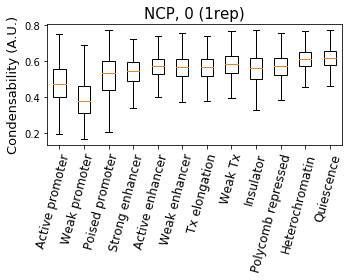

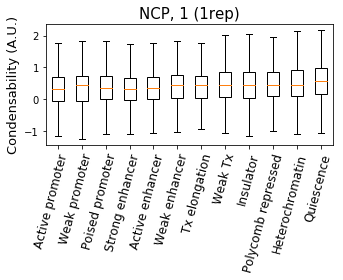

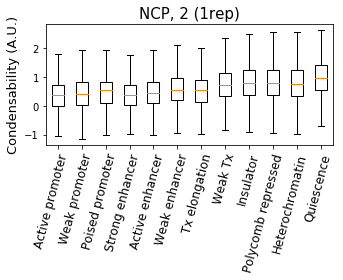

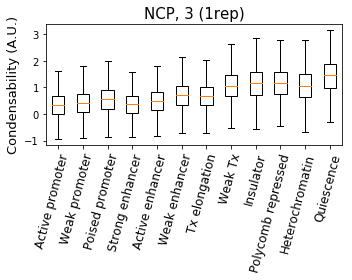

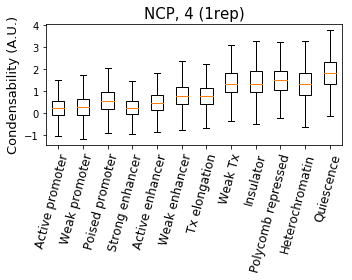

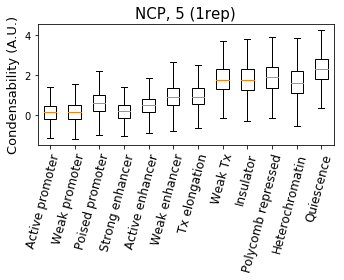

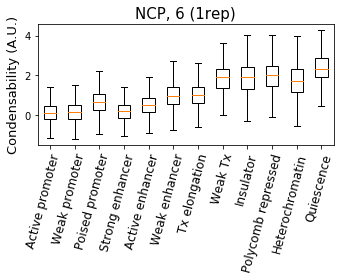

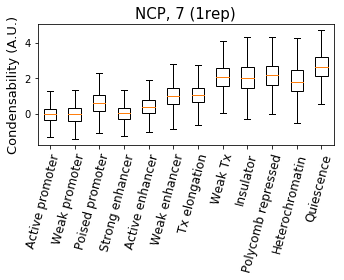

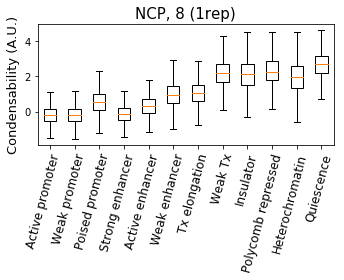

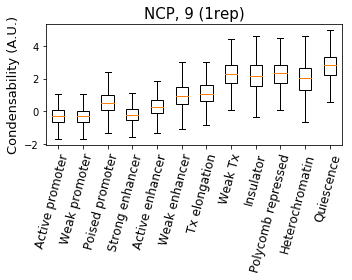

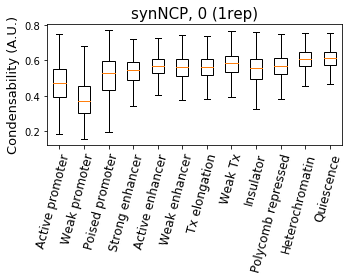

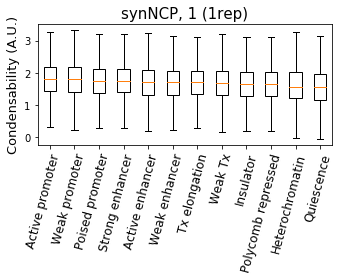

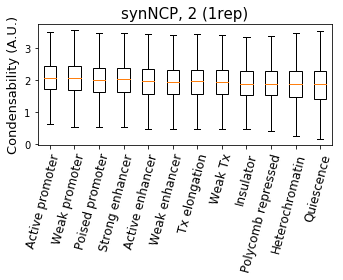

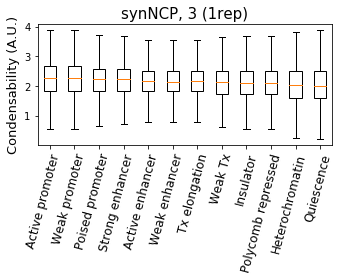

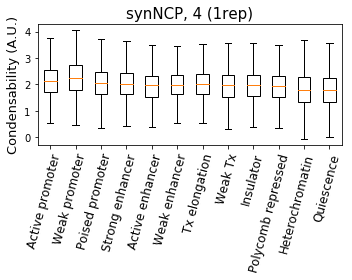

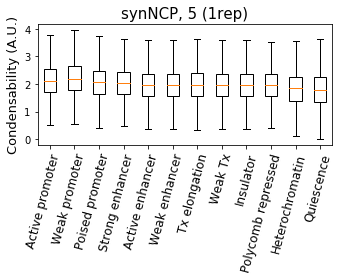

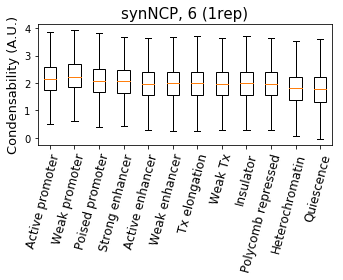

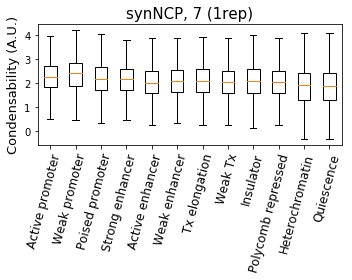

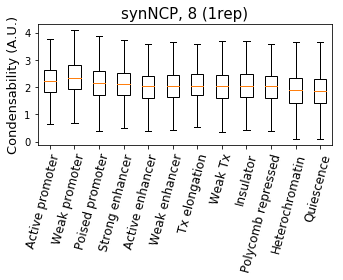

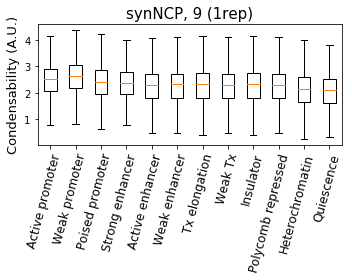

In [19]:
### plot the chromHMM
for dkey in sorted(dkey_state_values):
    state_values = dkey_state_values[dkey]
    
    graphics.plot_boxplot (state_values,
                           keys = states,
                           ylabel='Condensability (A.U.)',
                           title='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                           rotation=75,
                           fig_width=5,
                           fig_height=4,
                           ylabel_fontsize=13,
                           title_fontsize=15,
                           xticklabel_fontsize=12,
                           save_path='./data/',
                           save=False,
                           note='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]))
    print

(1, 'NCP', 'score', 1)


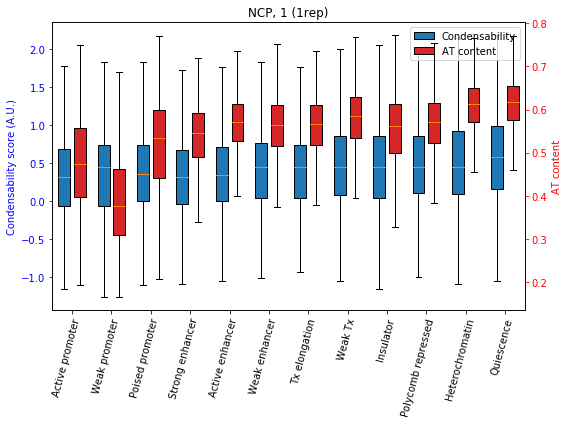


(1, 'NCP', 'score', 2)


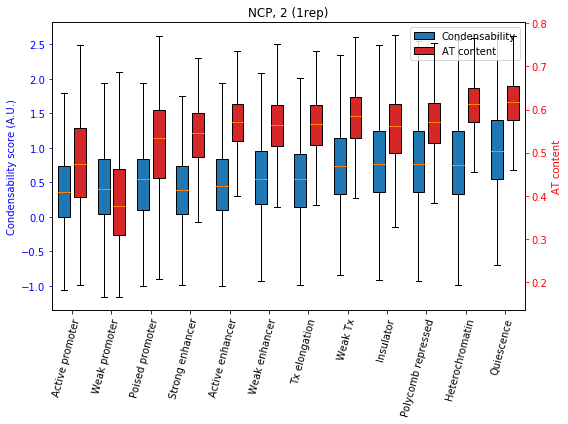


(1, 'NCP', 'score', 3)


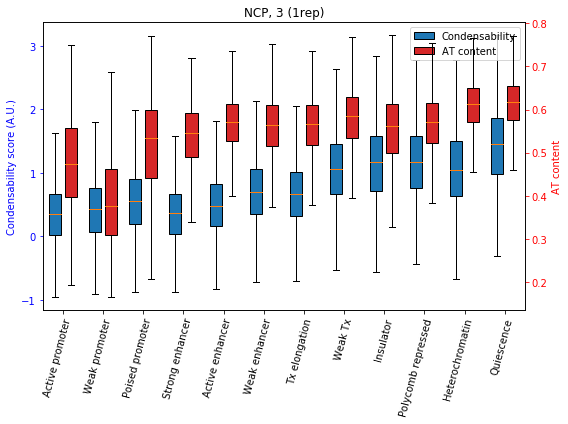


(1, 'NCP', 'score', 4)


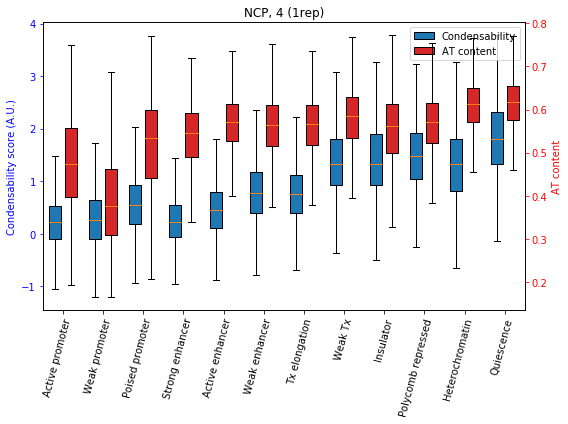


(1, 'NCP', 'score', 5)


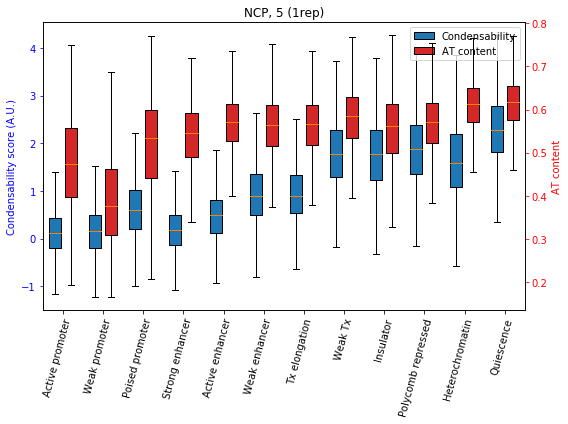


(1, 'NCP', 'score', 6)


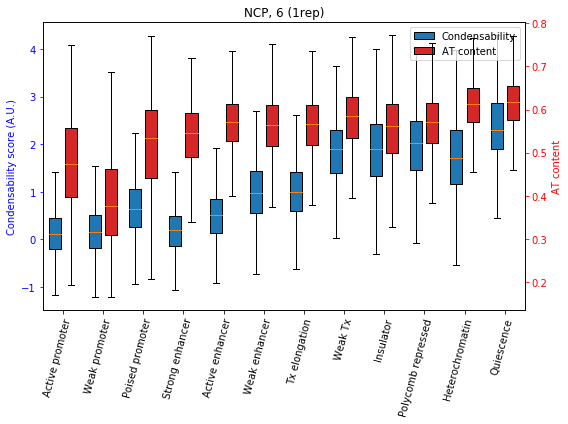


(1, 'NCP', 'score', 7)


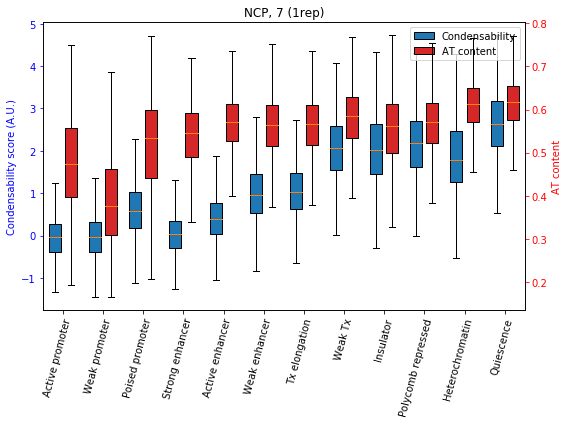


(1, 'NCP', 'score', 8)


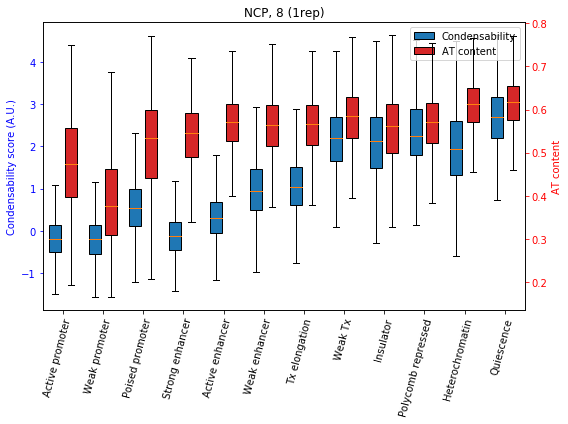


(1, 'NCP', 'score', 9)


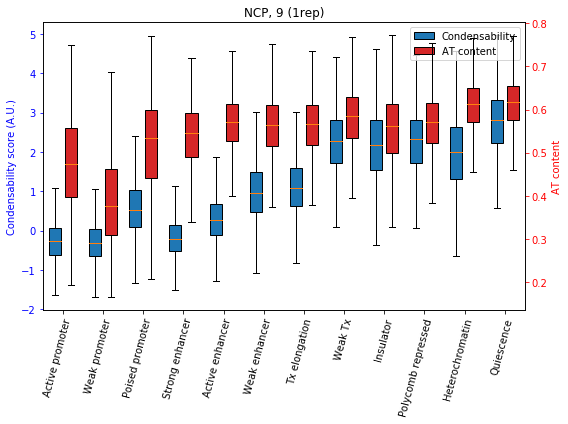


(1, 'synNCP', 'score', 1)


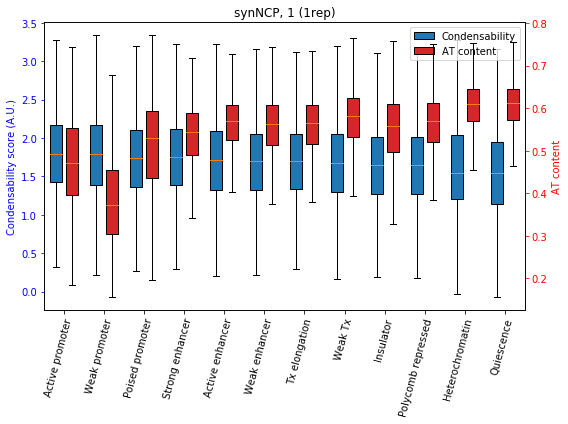


(1, 'synNCP', 'score', 2)


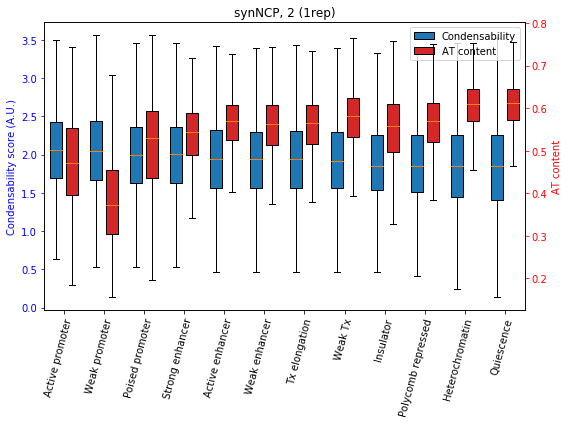


(1, 'synNCP', 'score', 3)


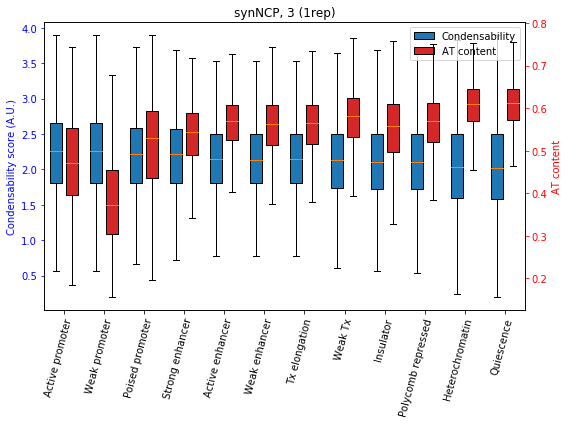


(1, 'synNCP', 'score', 4)


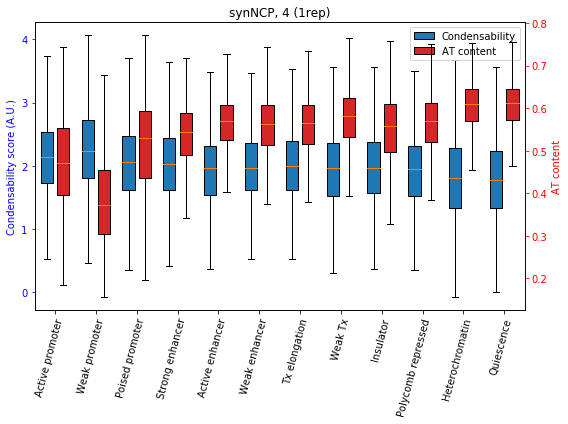


(1, 'synNCP', 'score', 5)


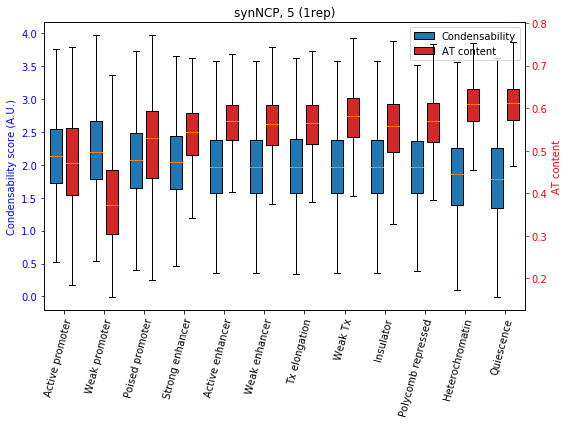


(1, 'synNCP', 'score', 6)


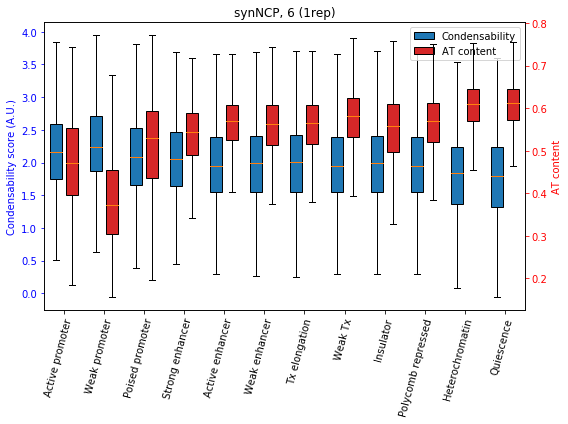


(1, 'synNCP', 'score', 7)


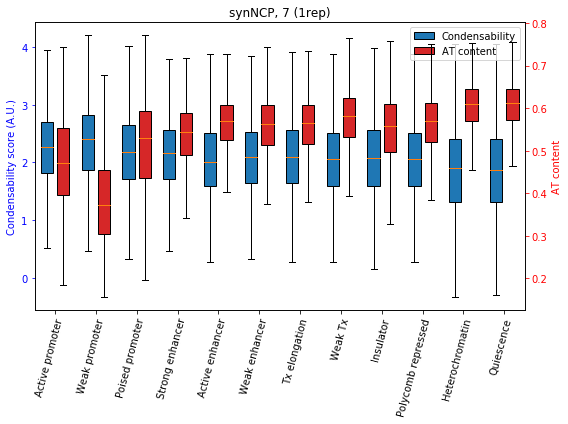


(1, 'synNCP', 'score', 8)


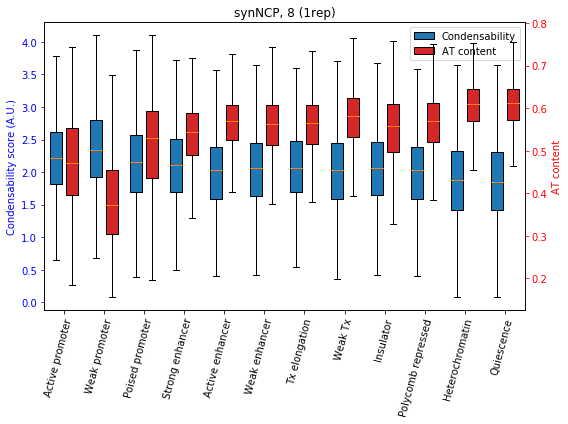


(1, 'synNCP', 'score', 9)


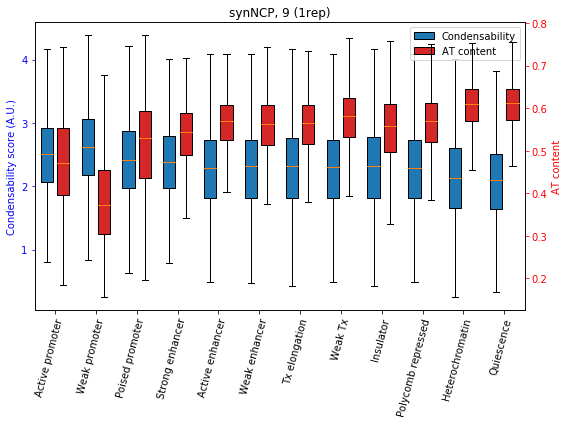

In [20]:
### plot the chromHMM (compare with AT content)
for dkey in sorted(dkey_state_values):
    if dkey[2] == 'ATcontent':
        continue
    print dkey
    graphics.plot_boxplot_pair (dkey_state_values[dkey],
                                dkey_state_values[(1, dkey[1], 'ATcontent', 0)],
                                keys=states,
                                color1='tab:blue',
                                color2='tab:red',
                                ycolor1='blue',
                                ycolor2='red',
                                ylabel1='Condensability score (A.U.)',
                                ylabel2='AT content',
                                label1='Condensability',
                                label2='AT content',
                                legend_loc='best',
                                title='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                                rotation=75,
                                note='%s, %s (%drep)' % (dkey[1], dkey[3], dkey[0]),
                                save_path='./data/',
                                save=False)
    print

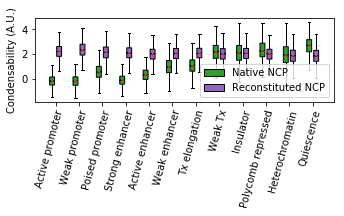

In [21]:
### plot the chromHMM (NCP vs synNCP)
dkey1 = (1, 'NCP', 'score', 8)
dkey2 = (1, 'synNCP', 'score', 8)
dkeys = [dkey1, dkey2]
colors = ['tab:green', 'tab:purple']
labels = ['Native NCP', 'Reconstituted NCP']

graphics.plot_boxplot_multiple ([dkey_state_values[dkey] for dkey in dkeys],
                                keys=states,
                                ylabel='Condensability (A.U.)',
                                rotation=75,
                                colors=colors,
                                labels=labels,
                                legend_loc='best',
                                fig_width=5,
                                fig_height=3,
                                note="GM_NCP_vs_synNCP",
                                save_path='./data/',
                                save=True)